# **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context**
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance.

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile


import cv2
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

**Let us check the version of tensorflow.**

In [3]:
tf.__version__

'2.18.0'

## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [75]:
# As we have h5 file we import h5py package
import h5py

pathH5 = '/content/drive/MyDrive/MIT/Elective Project /SVHN_single_grey1.h5'
f = h5py.File(pathH5, 'r')

f.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [76]:
# Select all rows and columns to assing it to X_train and y_train variables
X_train = f['X_train'][:]
y_train = f['y_train'][:]

# Select all rows and columns to assing it to X_test and y_test variables
X_test = f['X_test'][:]
y_test = f['y_test'][:]

Check the number of images in the training and the testing dataset.

In [77]:
# Use shape to see number of images and the format
print(f"Shape of training dataset: {X_train.shape}")
print(f"Shape of testing dataset: {X_test.shape}")

Shape of training dataset: (42000, 32, 32)
Shape of testing dataset: (18000, 32, 32)


**Observation:**

* We can see that tha training dataset has 42,000 images, and the testing dataset has 18,000 images, both with 32 x 32 images.

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

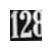

2


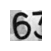

6


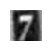

7


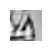

4


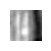

4


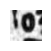

0


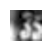

3


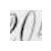

0


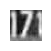

7


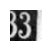

3


In [7]:
# Iterate to get the first 10 images and its labels
for i in range(10):
  plt.subplot(10, 1,i+1)

  plt.imshow(X_train[i], cmap='gray')

  plt.axis('off')

  plt.show()
  print(y_train[i])

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [78]:
# We get the shape and the array of pixels for first image

print(f"Shape:\n {np.array(X_train[0]).shape}")

print(f"\nArray of pixels:\n {X_train[0]}")

Shape:
 (32, 32)

Array of pixels:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


### **Normalize the train and the test data**

In [79]:
# We divide by 255 because is the max value for bits so its between 0-1
X_train = X_train/255.0
X_test = X_test/255.0

In [80]:
print(X_test.min(), X_test.max())

0.0 0.9999


Print the shapes of Training and Test data

In [81]:
print(f"Shape of training dataset: {X_train.shape}, {y_train.shape}")
print(f"Shape of testing dataset: {X_test.shape},  {y_test.shape}")

Shape of training dataset: (42000, 32, 32), (42000,)
Shape of testing dataset: (18000, 32, 32),  (18000,)


### **One-hot encode output**

In [82]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

**Observation:**
* As we can see now every entry of our target variable is One-Hot encoded, where the 1 is placed that is the class so supposed the classes goes from (0-9) if the vector is [0., 1., 0., and so on) it would mean that that vector is representing the number 1.

## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [83]:
import random

backend.clear_session()
# Declaring the seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [13]:
# Defining our model function nn_model_1
def nn_model_1():
  model = Sequential()

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))

  model.add(Conv2D(32, (3,3), activation='relu'))

  model.add(Flatten())

  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model


model = nn_model_1()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       250,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,994 (1.03 MB)

 Trainable params: 269,994 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=128, verbose=1, epochs=20)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 123s 464ms/step - accuracy: 0.4008 - loss: 1.8028 - val_accuracy: 0.7883 - val_loss: 0.7366
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 143s 470ms/step - accuracy: 0.8014 - loss: 0.6947 - val_accuracy: 0.8274 - val_loss: 0.6218
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 164s 552ms/step - accuracy: 0.8347 - loss: 0.5843 - val_accuracy: 0.8296 - val_loss: 0.6084
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 185s 488ms/step - accuracy: 0.8489 - loss: 0.5358 - val_accuracy: 0.8380 - val_loss: 0.5868
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 136s 465ms/step - accuracy: 0.8580 - loss: 0.5008 - val_accuracy: 0.8406 - val_loss: 0.5765
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 459ms/step - accuracy: 0.8651 - loss: 0.4738 - val_accuracy: 0.8419 - val_loss: 0.5699
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 121s 462ms/step - accuracy: 0.8707 - loss: 0.4538 - val_accuracy: 0.8433 - val_loss: 0.5657
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 124s 470ms/step - accuracy: 0.8773 -

### **Plot the Training and Validation Accuracies and write down your Observations.**

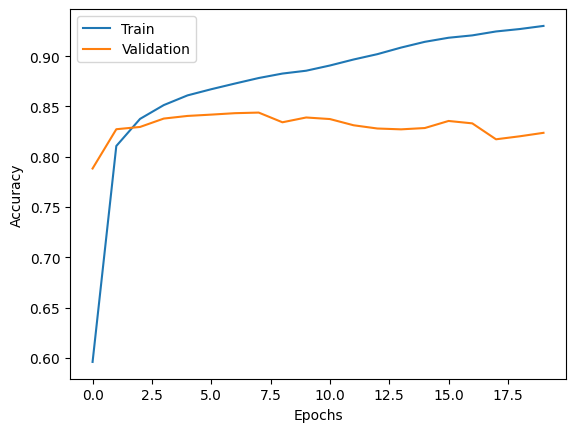

In [15]:
# Plotting training and validation

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**
* As we can see the model on the training data keeps improving with every epoch, it doesnt happen on the validation set, maybe the model does not generalize really good.
* After the 6 epoch it does not improve really we could use Early Stopping and data augmentation to improve generalization.

Let's build one more model with higher complexity and see if we can improve the performance of the model.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [72]:
import random
# Clearing session
backend.clear_session()

# Seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [84]:
def nn_model_2():
  model = Sequential()

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(32,32,1)))

  model.add(Conv2D(128, (3,3), activation='relu'))

  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), activation='relu'))

  model.add(Conv2D(64, (3,3), activation='relu'))

  model.add(Conv2D(32, (3,3), activation='relu'))

  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

  return model

In [85]:
model_2 = nn_model_2()
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       154,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 581,802 (2.22 MB)

 Trainable params: 581,738 (2.22 MB)

 Non-trainable params: 64 (256.00 B)

In [86]:
history_2 = model_2.fit(X_train, y_train,
                        validation_split=0.2,
                        batch_size=128,
                        verbose=1,
                        epochs=30)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.4428 - loss: 1.5667 - val_accuracy: 0.5904 - val_loss: 1.5780
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8458 - loss: 0.5195 - val_accuracy: 0.8460 - val_loss: 0.5938
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8700 - loss: 0.4348 - val_accuracy: 0.8340 - val_loss: 0.5726
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.8820 - loss: 0.3903 - val_accuracy: 0.7604 - val_loss: 0.9587
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8922 - loss: 0.3520 - val_accuracy: 0.7923 - val_loss: 0.9207
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9061 - loss: 0.3089 - val_accuracy: 0.7870 - val_loss: 0.9036
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9169 - loss: 0.2710 - val_accuracy: 0.8104 - val_loss: 0.7856
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9289 - loss: 0.2336 - 

### **Plot the Training and Validation Accuracies and write down your Observations.**

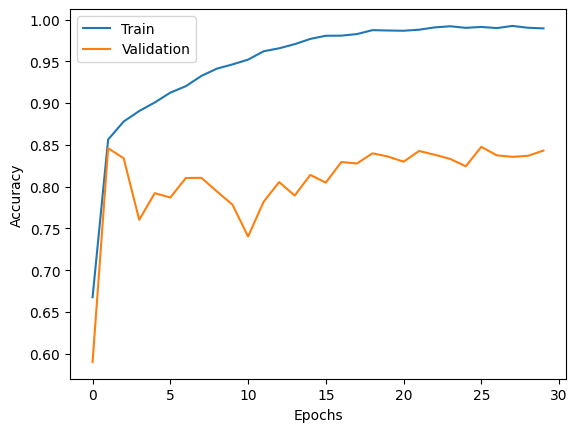

In [87]:
# Plot training and validation accuracy model_2

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**

* This second model has more hidden layers and a different learning rate for the optimizer, has BatchNormalization.
* The performance on the validation set we can see that in early epochs, the accuracy goes up and then down back again and does not improve much after that first peak, we have now a more complex model, but dont get better generalization, maybe there is overfitting.
* Probably we would need to apply MaxPooling, Data Augmentation and an Early Stopping.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [88]:
# Assigning to y_pred the prediction and then converting each entry to single label
y_pred = model_2.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [89]:
# With this code we convert each entry to a single label
y_test = np.argmax(y_test, axis = -1)

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1814
           1       0.89      0.82      0.86      1828
           2       0.89      0.85      0.87      1803
           3       0.77      0.81      0.79      1719
           4       0.88      0.84      0.86      1812
           5       0.79      0.86      0.83      1768
           6       0.82      0.82      0.82      1832
           7       0.86      0.88      0.87      1808
           8       0.82      0.79      0.81      1812
           9       0.79      0.86      0.82      1804

    accuracy                           0.84     18000
   macro avg       0.84      0.84      0.84     18000
weighted avg       0.84      0.84      0.84     18000



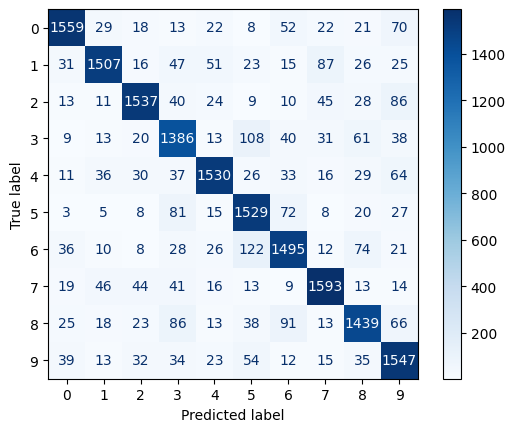

In [92]:
# Print Classification report
print(classification_report(y_test, y_pred))

# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

**Final Observations:**
* The model rarely misses 0s has pretty good recall.
* Numbers 5, 6, 8 and 9 have pretty similar metrics, pretty solid but nothing super special, maybe because the model misclassified or get confused between this fours numbers.
* Accuracy is pretty high with 0.87 overall, is pretty good.
* On the confusion matrix we can see that some 4s are classified as 1s, some 5s are classified as 3s and 9s as already mentioned.
* Number 6s are mostly misclassified as 0s and 8s, and 9s are misclassified mostly as 0s.

## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [50]:
import h5py

pathH5 = '/content/drive/MyDrive/MIT/Elective Project /SVHN_single_grey1.h5'

cnn = h5py.File(pathH5, 'r')

cnn.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

Check the number of images in the training and the testing dataset.

In [51]:
# Select all rows and columns to assing it to X_train and y_train variables
X_train = cnn['X_train'][:]
y_train = cnn['y_train'][:]

# Select all rows and columns to assing it to X_test and y_test variables
X_test = cnn['X_test'][:]
y_test = cnn['y_test'][:]

print(f"Shape of training set: {X_train.shape}")
print(f"Shape of testing set: {X_test.shape}")

Shape of training set: (42000, 32, 32)
Shape of testing set: (18000, 32, 32)


**Observation:**
* Each image is 32x32 pixels, its assumed that is grey colors as there is no third number as that training set has 42k images and the testing set has 18k.

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [52]:
# Shape of first image on the training dataset
print(f"Shape of pixels: {X_train[0].shape}")

print('*'*50)

# Array of the first image on the training dataset
print(f"Shape of first image:\n {X_train[0]}")

Shape of pixels: (32, 32)
**************************************************
Shape of first image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [53]:
# Reshaping both datasets to give a 4D array
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

Normalize inputs from 0-255 to 0-1

In [54]:
# Normalizing the datasets so they go from 0-1
X_train = X_train/255.0
X_test = X_test/255.0

Print New shape of Training and Test

In [55]:
# We see the changes we did adding the 4D array
print(f"New shape of training dataset: {X_train.shape}")
print(f"New shape of testing dataset: {X_test.shape}")

New shape of training dataset: (42000, 32, 32, 1)
New shape of testing dataset: (18000, 32, 32, 1)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [56]:
# We encode our target variables with to_categorical function
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

**Observation:**

* As we can see now is an encoded vector.

## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [57]:
import random

backend.clear_session()

seed= 42

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [58]:
# Building the model with a function
def cnn_model_1():
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32,32,1)))
  model.add(LeakyReLU(alpha=0.1))

  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(32))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model

# Initialize model
cnn_model1 = cnn_model_1()
# Model summary
cnn_model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,306 (1.02 MB)

 Trainable params: 267,306 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Fit the model
history = cnn_model1.fit(X_train, y_train, validation_split=0.2, batch_size=32, verbose=1, epochs=20)

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4286 - loss: 1.6247 - val_accuracy: 0.8163 - val_loss: 0.6319
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8338 - loss: 0.5621 - val_accuracy: 0.8325 - val_loss: 0.5648
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8692 - loss: 0.4562 - val_accuracy: 0.8556 - val_loss: 0.5129
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8853 - loss: 0.3931 - val_accuracy: 0.8589 - val_loss: 0.5090
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8992 - loss: 0.3435 - val_accuracy: 0.8648 - val_loss: 0.5019
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9137 - loss: 0.3009 - val_accuracy: 0.8663 - val_loss: 0.5200
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9244 - loss: 0.2658 - val_accuracy: 0.8635 - val_loss: 0.5364
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9308 - loss: 0.2380 -

### **Plot the Training and Validation Accuracies and Write your observations.**

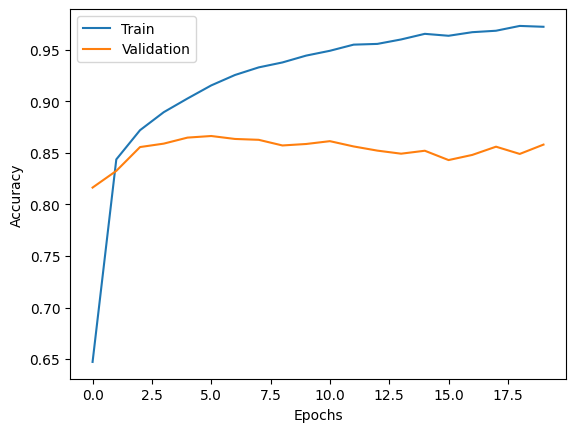

In [60]:
# Plotting line of training and validation accuracies

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**
* Almost the same as past models, in first epochs accuracy goes up pretty quickly and then for the validation set, it stabilizes after the fifth epoch, and does not improve much after that, and training set keeps improving still on last epoch.
* We have a problem maybe of overfitting or lack of generalization of our model on validation set.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [61]:
backend.clear_session()
# Starting the seed and clearing the session
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [62]:
# Creating the model with the function
def cnn_model_2():
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32,32,1)))
  model.add(LeakyReLU(alpha=0.1))

  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(BatchNormalization())

  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.1))

  model.add(Conv2D(64, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(32))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model

In [63]:
# Initializing model
cnn_model2 = cnn_model_2()

# Model summary
cnn_model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,362 (642.04 KB)

 Trainable params: 164,170 (641.29 KB)

 Non-trainable params: 192 (768.00 B)

In [64]:
# Fitting Model
history_2 = cnn_model2.fit(X_train, y_train, validation_split=0.2, batch_size=128, verbose=1, epochs=30)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.3297 - loss: 1.9242 - val_accuracy: 0.3945 - val_loss: 1.8369
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7746 - loss: 0.7253 - val_accuracy: 0.8506 - val_loss: 0.5160
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8223 - loss: 0.5767 - val_accuracy: 0.8696 - val_loss: 0.4552
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8486 - loss: 0.4963 - val_accuracy: 0.8737 - val_loss: 0.4396
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8631 - loss: 0.4415 - val_accuracy: 0.8785 - val_loss: 0.4252
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8744 - loss: 0.4120 - val_accuracy: 0.8905 - val_loss: 0.3893
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8807 - loss: 0.3884 - val_accuracy: 0.8893 - val_loss: 0.4051
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8916 - loss: 0.3523 - val_acc

### **Plot the Training and Validation accuracies and write your observations.**

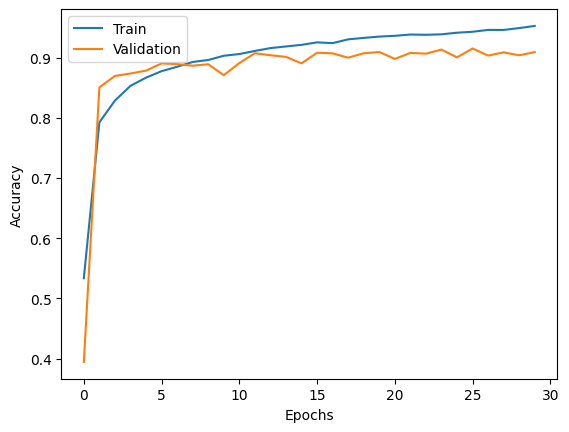

In [65]:
# Plotting line chart of training and validation sets

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**Observations:________**

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.**

In [66]:
# Assigning to y_pred the prediction and then converting each entry to single label
y_pred = cnn_model2.predict(X_test)

y_pred = np.argmax(y_pred, axis=-1)

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [67]:
# With this code we convert each entry to a single label
y_test = np.argmax(y_test, axis = -1)

### **Write your final observations on the performance of the model on the test data.**

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1814
           1       0.89      0.90      0.90      1828
           2       0.92      0.93      0.92      1803
           3       0.87      0.89      0.88      1719
           4       0.90      0.93      0.92      1812
           5       0.91      0.89      0.90      1768
           6       0.88      0.91      0.90      1832
           7       0.94      0.92      0.93      1808
           8       0.88      0.90      0.89      1812
           9       0.93      0.88      0.91      1804

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



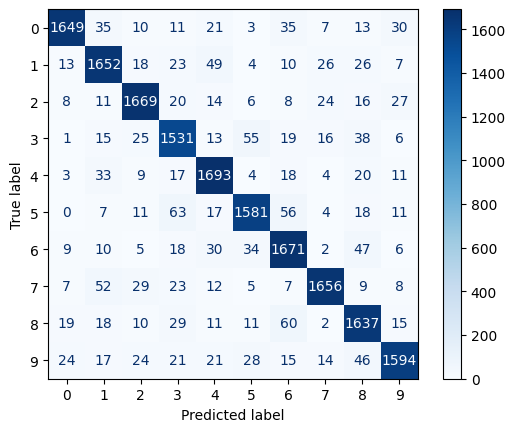

In [71]:
# Printing classification report of our CNN model
print(classification_report(y_test, y_pred))

# Plotting confusion matrix of CNN model
# On this confusion matrix I tried using Display as used on the Optional Practice
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

**Final Observations:**
* As final observations we see that we get our best accuracy 0.91 than any other model pretty good performance.
* Using BatchNormalization and Dropout layers helped the model with generalization.
* All classes recall are above 0.88 which is pretty good, as we saw on other model those metrics where not so good in some numbers, in this model its different. This means the model does not has preferences for one specific class.
* Although model still confuses some number with others, the most common is predicting 6 and 3 when its really 8, caused because of similirity on the writing.
* It also confuses predicting actual number 7s with 1s mostly, numbers 5s with 6s, number 3s with 5s.
* As a mention on past models we can add data augmentation, rotation, etc or more layers to increase the accuracy of the model.

**Final Model**
* As the final model we stay with this last model cnn_model2 with more hidden layers, maxpooling, etc because it showed a better accuracy, in comparison with other model, it predicts better all classes its macro avg its also betters than other models that means its not bias by one class or specific group of classes.